# LiDAR Uncertainty in Canopat the SOAP and SJER NEON sites

## The SOAP site
![Soaproot Panorama](img/Soaproot_pano.jpeg)
Image credit: National Ecological Observtory Network, available at: https://www.neonscience.org/field-sites/soap

In [1]:
import os
import pathlib

import earthpy as et
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import SJERDataLoader, SOAPDataLoader 

et.data.get_data('spatial-vector-lidar')

home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)
os.chdir(home_dir)

# Create instances of class for SJER and SOAP

In [2]:
# Use child classes to create instances of class for sjer and soap 
sjer_data_loader = SJERDataLoader()
soap_data_loader = SOAPDataLoader()
#sjer_data_loader.height_stats
##soap_data_loader.height_stats

# Plot lidar vs insitu mean and max canopy height 
(using the plot_height method of NEONDataLoader class)

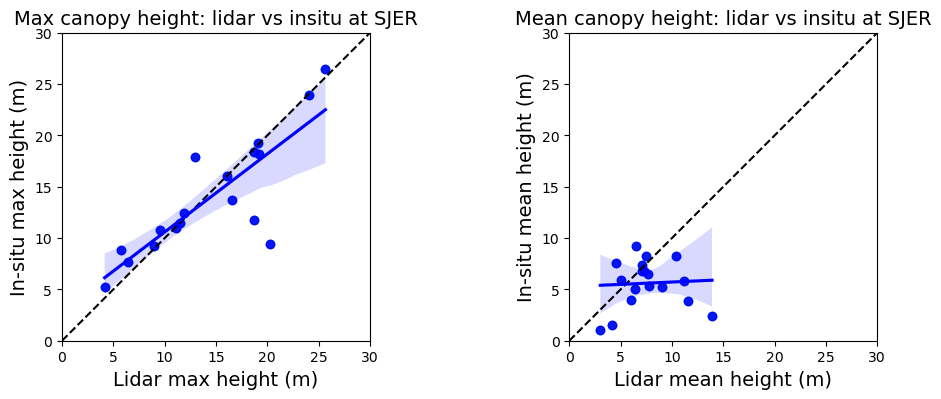

In [3]:
# Plot SJER data
sjer_data_loader.plot_height(site_name='SJER', 
                             ax1max = 30, 
                             ax2max = 30)

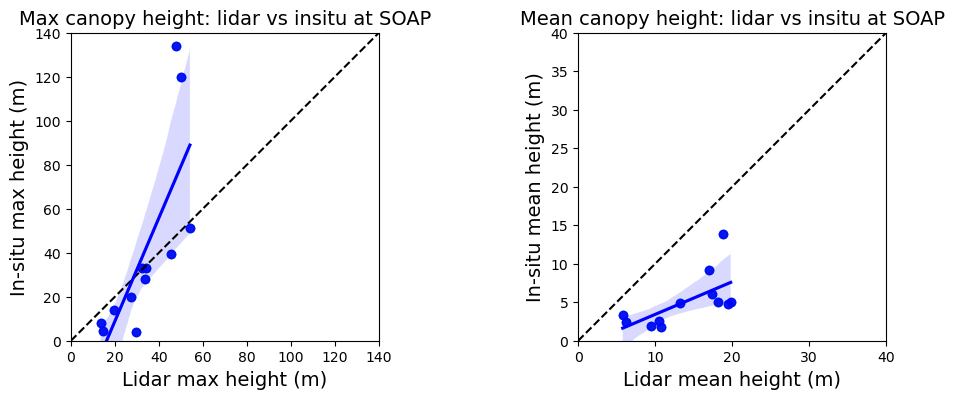

In [4]:
# Plot SOAP data
soap_data_loader.plot_height(site_name='SOAP', 
                             ax1max = 140, 
                             ax2max = 40)